# import torch 
import numpy as np
from matplotlib import pyplot as plt
import time

from solver import Solver
from dataset import SytheticData
from model import multilayer, box_smooth
from utils_plot import plot_model, plot_section

In [2]:
# Device 
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(f'device={device}')

KeyboardInterrupt: 

In [ ]:
# Mesh Configurations
h = 0.015
dt = 0.001
nx = 200
nz = 100
nt = 1200
f0 = 10
t0 = 1/f0

cfl = 4 * dt / h
npw = 4 / f0 / h
print('CFL number is about' + f' {cfl:.2f}')
print('Number of grid points per wave length is about' + f' {npw:.1f}')

In [ ]:
# Training configurations
num_epochs = 120
batch_size = 16
# batch_size = 8
learning_rate = 0.01
shuffle = True

In [ ]:
# Sources and receivers
sx = np.arange(1, nx, 2)
sources_xz = np.c_[np.ones_like(sx), sx]
rx = np.arange(1, nx)
receivers_xz = np.c_[2*np.ones_like(rx), rx]

In [6]:
# True model
wavespeed = multilayer(nz, nx)
wavespeed /= 1000

Text(0.5, 1.0, 'wavespeed in Marmousi')

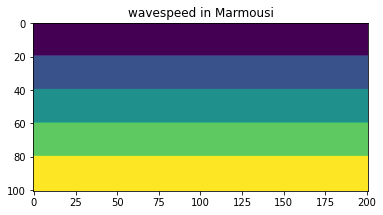

In [7]:
plt.imshow(wavespeed, aspect='equal')
plt.title(r'wavespeed in Marmousi')

In [8]:
print('wavespeed in ({:.2f}, {:.2f})'.format(wavespeed.min(), wavespeed.max()))

wavespeed in (1.50, 3.50)


In [9]:
wavespeed_true = torch.from_numpy(wavespeed).to(torch.float32)

In [10]:
# Dataset and dataloader
dataset = SytheticData(wavespeed_true, h, dt, nt, t0, f0, sources_xz, receivers_xz)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [11]:
# Initial model
wavespeed_initial = box_smooth(wavespeed_true, 40, 40).to(device)
wavespeed_initial_numpy = wavespeed_initial.clone().cpu().numpy()
wavespeed_initial.requires_grad = True

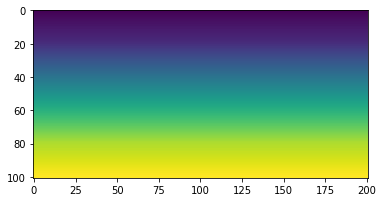

In [12]:
plt.imshow(wavespeed_initial_numpy)

In [13]:
# Initial solver
solver_initial = Solver(wavespeed_initial, h, dt, nt, t0, f0, receivers_xz)

In [14]:
# Loss function
criterion = torch.nn.MSELoss()

In [15]:
# Optimizer 
all_params = [wavespeed_initial]
# optimizer = torch.optim.Adam(all_params, lr=learning_rate)
# optimizer = torch.optim.RMSprop(all_params, lr=learning_rate)
optimizer = torch.optim.NAdam(all_params, lr=learning_rate)
# optimizer = torch.optim.Adamax(all_params, lr=learning_rate)
# optimizer = torch.optim.Adadelta(all_params, lr=learning_rate)
# optimizer = torch.optim.Adagrad(all_params, lr=learning_rate)

In [16]:
# Logger 
loss_list = []
# loss_t_list = []
# def  seis_t(v):
#     v_t = (v[:, :, 1:] - v[:, :, :-1]) / dt
#     return v_t

In [ ]:
# Training
time_begin_train = time.time()
n_batch = 0
for n_epoch in range(num_epochs):
    for i, data in enumerate(dataloader):
        n_batch += 1
        time_begin = time.time()
        sx, obs = data 
        optimizer.zero_grad()
        syn = solver_initial.step(sx)
        # syn_t = seis_t(syn)
        # obs_t = seis_t(obs)
        loss_val = criterion(syn, obs.to(device))
        #l oss_t_val = criterion(syn_t, obs_t.to(device))
        # loss_total_val = loss_val + loss_t_val
        # loss_total_val.backward()
        loss_val.backward()
        loss_list.append(loss_val.item())
        # loss_t_list.append(loss_val.item())
        optimizer.step()
        time_end = time.time()
        print(f"Epoch {n_epoch+1}, Batch {n_batch}, loss={loss_val:.6f}, time={time_end - time_begin:.2f}s")
        # print(f"Epoch {n_epoch+1}, Batch {n_batch}, loss_total={loss_total_val:.6f}, loss={loss_val:.6f}, loss_t={loss_t_val:.6f}, time={time_end - time_begin:.2f}s")
time_end_train = time.time()
print(f'Total cost time {time_end_train - time_begin_train:.2f}s')

Epoch 1, Batch 1, loss=0.270541, time=14.14s
Epoch 1, Batch 2, loss=0.229802, time=13.30s
Epoch 1, Batch 3, loss=0.180285, time=15.00s
Epoch 1, Batch 4, loss=0.171030, time=17.59s
Epoch 1, Batch 5, loss=0.162382, time=16.13s
Epoch 1, Batch 6, loss=0.142711, time=16.48s
Epoch 1, Batch 7, loss=0.117275, time=17.13s
Epoch 2, Batch 8, loss=0.123605, time=16.95s
Epoch 2, Batch 9, loss=0.112624, time=15.85s
Epoch 2, Batch 10, loss=0.090372, time=15.43s
Epoch 2, Batch 11, loss=0.091249, time=16.78s
Epoch 2, Batch 12, loss=0.083472, time=16.70s
Epoch 2, Batch 13, loss=0.096552, time=16.71s
Epoch 2, Batch 14, loss=0.083987, time=16.06s
Epoch 3, Batch 15, loss=0.070668, time=17.12s
Epoch 3, Batch 16, loss=0.071627, time=16.86s
Epoch 3, Batch 17, loss=0.068095, time=14.58s
Epoch 3, Batch 18, loss=0.062642, time=17.29s
Epoch 3, Batch 19, loss=0.056593, time=17.04s
Epoch 3, Batch 20, loss=0.055074, time=16.85s
Epoch 3, Batch 21, loss=0.058488, time=15.78s
Epoch 4, Batch 22, loss=0.046452, time=17.0

In [ ]:
wavespeed_inversion = wavespeed_initial.detach().cpu().numpy()

In [ ]:
plt.imshow(wavespeed_inversion)

In [ ]:
plt.imshow(wavespeed_initial_numpy)

In [ ]:
ncol = 100
plt.plot(wavespeed_inversion[:, ncol], label='inversion')
plt.plot(wavespeed_true[:, ncol], label='true')
plt.plot(wavespeed_initial_numpy[:, ncol], label='initial')
plt.legend()

In [ ]:
plt.plot(loss_list)
plt.yscale('log')

In [ ]:
path = './data/multilayer_/'#!!!!
np.save(path+'wavespeed_true', wavespeed)
np.save(path+'wavespeed_initial', wavespeed_initial_numpy)
np.save(path+'wavespeed_inversion', wavespeed_inversion)
np.save(path+'loss', np.array(loss_list))
# np.save(path+'loss_t', np.array(loss_t_list))